## Machine Learning to Predict Yelp Ratings from Attributes

The goal of this project is to explore the power of Yelp metadata attributes to predict the rating of a venue. Yelp collects a lot of data on businesses (See [Yelp Developer Docs](https://www.yelp.com/developers/documentation/v2/business)). I will focus on:

* city - city in which the business resides
* longitude & latitude - coordinates of business
* categories - provides a list of catogories the business is associated with
* attributes - a list of various features (Take Out, Waiter Service, Alcohol, etc.)

How predictive are the 'characteristics' of the restaurant for star ratings?

In [10]:
import pandas as pd
import gzip
import simplejson
import re
from sklearn.cross_validation import train_test_split
import matplotlib
import seaborn as sns
from sklearn import metrics
import matplotlib.pylab as plt
import sklearn
import numpy as np
from sklearn import base
from sklearn.externals import joblib
from sklearn import neighbors, cross_validation, grid_search
import matplotlib.pylab as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import linear_model

plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_columns=25

In [2]:
data = gzip.open('yelp_train_academic_dataset_business.json.gz')
data_content = data.read()
data.close()
lines= re.split('\n',data_content)
json_data = [simplejson.loads(line) for line in lines[:-1]]
df = pd.DataFrame(json_data)
data_as_dict = [dict(df.iloc[i]) for i in xrange(len(df))]
df[:5]

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,{u'By Appointment Only': True},vcNAWiLM4dR7D2nwwJ7nCA,"[Doctors, Health & Medical]",Phoenix,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{u'Tuesday': {u'close': u'17:00', u'open': u'0...",33.499313,-111.983758,"Eric Goldberg, MD",[],True,7,3.5,AZ,business
1,"{u'Take-out': True, u'Price Range': 1, u'Outdo...",JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,"6162 US Highway 51\nDe Forest, WI 53532",{},43.238893,-89.335844,Pine Cone Restaurant,[],True,26,4.0,WI,business
2,"{u'Take-out': True, u'Outdoor Seating': False,...",uGykseHzyS5xAMWoN6YUqA,"[American (Traditional), Restaurants]",De Forest,"505 W North St\nDe Forest, WI 53532","{u'Monday': {u'close': u'22:00', u'open': u'06...",43.252267,-89.353437,Deforest Family Restaurant,[],True,16,4.0,WI,business
3,"{u'Take-out': True, u'Accepts Credit Cards': T...",LRKJF43s9-3jG9Lgx4zODg,"[Food, Ice Cream & Frozen Yogurt, Fast Food, R...",De Forest,"4910 County Rd V\nDe Forest, WI 53532","{u'Monday': {u'close': u'22:00', u'open': u'10...",43.251045,-89.374983,Culver's,[],True,7,4.5,WI,business
4,"{u'Take-out': True, u'Has TV': False, u'Outdoo...",RgDg-k9S5YD_BaxMckifkg,"[Chinese, Restaurants]",De Forest,"631 S Main St\nDe Forest, WI 53532","{u'Monday': {u'close': u'22:00', u'open': u'11...",43.240875,-89.343722,Chang Jiang Chinese Kitchen,[],True,3,4.0,WI,business


In [3]:
print df.shape

(37938, 15)


Above, we can see the structure of the data. The 5 categories I will use are attributes, categories, city, latitude, longitude.  Notice that both attribues and categories have different lengths and may be nested (attributes in particular).

### Transformers
To make this data place nice in sklearn, I have constructed the following generic column transformer, category transformer, and attribute transformer.

In [4]:
from sklearn.base import TransformerMixin

class ColumnSelectTransformer(TransformerMixin):
    '''
    ColumnSelectTransformer provides a generic transformer to select columns from our input list/dict.
    '''
    def __init__(self, columns=None):
        if columns:
            self.columns = columns
        else:
            self.columns = ['business_id']
    
    def transform(self, record, *args, **transform_params):
        if isinstance(record,dict):
            #print 'received dict'
            return [record[arg] for arg in self.columns]
        elif isinstance(record,list):
            #print 'received list'
            return [[rec[arg] for arg in self.columns] for rec in record]
        
    def fit(self, X, y=None, **fit_params):
        
        return self
        
class CategoryTransformer(TransformerMixin):
    '''
    CategorySelectTransformer provides a transformer to select handle the category field
    of our input data. There may be multiple, nested categories, this class builds an array of dictionaries 
    pointing to each category
    '''    
    def transform(self, record, *args, **transform_params):
        if isinstance(record,dict):     
            return dict([[cat, 1] for cat in record])
        elif isinstance(record,list):
            if len(record)==1:
                return [dict([[cat, 1] for cat in rec]) for rec in record]
            else:
                return [dict([[cat, 1] for cat in rec]) for inner in record for rec in inner]
                
    def fit(self, X, y=None, **fit_params):        
        return self
        
class ModelTransformer(TransformerMixin):
    '''
    ModelTransformer is a wrapper class to make an estimator act like a transformer
    This 'transforms' the data by using predict from the model to transform the data
    '''

    def __init__(self, model, name):
        self.model = model
        self.name = name

    def fit(self, *args, **kwargs):
        #print 'FITTING!'
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return [self.model.predict(x) for x in X]
        

def unnest_attributes(att,outer_key=None):
    '''
    This recursive function seeks to unnest the attributes within the attribute meta data of yelp.
    '''
    mydict = {}
    if not outer_key:
        outer_key = ''
    else:
        outer_key += '_'
        
    for key in att.keys():
        if isinstance(att[key],dict):
            inner_dict = unnest_attributes(att[key],key)
            for key in inner_dict.keys():
                mydict[outer_key+key] = inner_dict[key]
        else:
            mydict[outer_key+key] = att[key]
    
    return mydict

class AttributesTransformer(TransformerMixin):
    '''
    AttributesTransformer is a class to handle the attributes field.
    
    Attributes can be nested and there are often many for each venue.  This works with the unnest_attributes
    function to build an array of dictionaries of attributes within the yelp dataset.
    '''
    def transform(self, record, *args, **transform_params):
        if isinstance(record,dict):     
            return unnest_attributes(record)
        elif isinstance(record,list):
            if len(record)==1:
                return [unnest_attributes(rec) for rec in record]
            else:
                return [unnest_attributes(rec) for inner in record for rec in inner]
                
        
    def fit(self, X, y=None, **fit_params):
        
        return self

cst = ColumnSelectTransformer(columns=['latitude','longitude'])
print cst.transform(data_as_dict[0])

[33.499313000000001, -111.98375799999999]


### City Predictor
The first model I will try is the city predictor. It's a very simple model, where I return the mean value of stars in a given city.


In [5]:
from sklearn.base import BaseEstimator, RegressorMixin

class CityMeanEstimator(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y):
        X=[v[0] for v in X]
        df=pd.DataFrame({'city': X, 'stars': y},columns=['city','stars'])
        df['stars']=df['stars'].astype(float)
        self.f = df.groupby('city').mean()
        return self
    
    def predict(self, X):
        X=[v[0] for v in X]
        val=[]
        for x in X:
            if x in self.f.index:
                val.append(x)
            else:
                val.append('Chandler')
        return [x[0] for x in self.f.loc[val].values]

from sklearn.pipeline import FeatureUnion, Pipeline        
pipeline = Pipeline([
  ('cst', ColumnSelectTransformer(columns=['city'])),
  ('classifier', CityMeanEstimator())
])

There's my model above. I use the Pipeline feature of sklearn to transform my data for each model I create. This way, I can always input my full data, and have the pipeline select the features for me.

Okay, I will split up the data into train and test set using `train_test_split`

In [6]:
data_train, data_test, stars_train, stars_test = cross_validation.train_test_split(data_as_dict, df['stars'], random_state=23)

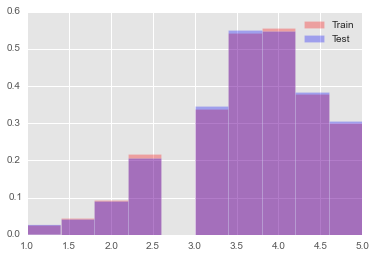

In [11]:
#check our distributions of stars between train and test
stars_train.hist( alpha=0.3 ,stacked=False,normed=True,color='red')
stars_test.hist( alpha=0.3 ,stacked=False,normed=True,color='blue')
plt.legend(['Train','Test'])

 Now, fit and score the model.

In [8]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
pipeline.fit(data_train, stars_train)

print pipeline.predict(data_test[:10])
print stars_test[:10].values
score = pipeline.score(data_test,stars_test)
print score
preds = pipeline.predict(data_test)
print 'City Model RMSE: ', mean_squared_error(stars_test,preds)**0.5
print 'City Model MAE: ', mean_absolute_error(stars_test,preds)
print 'City Model R^2: ', r2_score(stars_test,preds)

[3.6499816872176778, 3.585046066619419, 3.6655675459632295, 3.6361185983827493, 3.6499816872176778, 3.8244243421052633, 3.6655675459632295, 3.8080519480519479, 3.4166666666666665, 3.6499816872176778]
[ 5.   4.   4.5  4.5  3.5  5.   4.   3.5  4.   5. ]
0.00132602324228
City Model RMSE:  0.885138625141
City Model MAE:  0.711788533327
City Model R^2:  0.00132602324228


Bunk! It has about zero predictive value. The score that is displayed is the $R^2$ coefficient of determination. The best possible score is 1.0, and lower values are worse. So we can see that this model is not very predictive. But did we really expect the city a business is in to be a factor? I know the old trope that the 3 most important things for a business are: 
1. location
2. location
3. location

Well, city must not be specific enough. I will try latitude and longitude next. Perhaps it will be beter.

### Longitude and Latitude K-Nearest Neighbors Regression Model
The target is predicted by local interpolation of the values of its k nearest neighbors.

In [12]:
#kn = neighbors.KNeighborsRegressor()
pipeline = Pipeline([
  ('cst', ColumnSelectTransformer(columns=['latitude','longitude'])),
  ('classifier', neighbors.KNeighborsRegressor())
])
#latlon_train = cst.transform(data_train)
#kn.fit(latlon_train,stars_train)
#latlon_test = cst.transform(data_test)
#score = kn.score(latlon_test,stars_test)
pipeline.fit(data_train, stars_train)

print pipeline.predict(data_test[:10])
print stars_test[:10].values
score = pipeline.score(data_test,stars_test)
print score
preds = pipeline.predict(data_test)
print 'LatLong Model RMSE: ', mean_squared_error(stars_test,preds)**0.5
print 'LatLong Model MAE: ', mean_absolute_error(stars_test,preds)
print 'LatLong Model R^2: ', r2_score(stars_test,preds)

[ 4.1  3.8  4.   3.8  3.5  4.5  3.4  3.6  3.1  4.5]
[ 5.   4.   4.5  4.5  3.5  5.   4.   3.5  4.   5. ]
-0.0896369900153
LatLong Model RMSE:  0.924571165323
LatLong Model MAE:  0.733726937269
LatLong Model R^2:  -0.0896369900153


I need to tune this model to improve the score. I will use `GridSearchCV` with a `ShuffleSplit` cross validation

In [13]:
latlon = df.loc[:,['latitude','longitude']]
cv = cross_validation.ShuffleSplit(len(df['stars']), n_iter=20, test_size=0.2, random_state=23)
param_grid = { "n_neighbors": range(80, 100, 5)}
nearest_neighbors_cv = grid_search.GridSearchCV(neighbors.KNeighborsRegressor(), param_grid=param_grid, cv=cv)
nearest_neighbors_cv.fit(latlon,df['stars'])
nearest_neighbors_cv.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=85, p=2, weights='uniform')

The best estimator uses 85 neighbors by default for k_neighbors queries.

In [14]:
pipeline = Pipeline([
  ('cst', ColumnSelectTransformer(columns=['latitude','longitude'])),
  ('classifier', nearest_neighbors_cv.best_estimator_)
])

pipeline.fit(data_train, stars_train)
score = pipeline.score(data_test,stars_test)
print score
preds = pipeline.predict(data_test)
print 'LatLong GridCV Model RMSE: ', mean_squared_error(stars_test,preds)**0.5
print 'LatLong GridCV Model MAE: ', mean_absolute_error(stars_test,preds)
print 'LatLong GridCV Model R^2: ', r2_score(stars_test,preds)

0.0248118636604
LatLong GridCV Model RMSE:  0.874668790703
LatLong GridCV Model MAE:  0.699430680021
LatLong GridCV Model R^2:  0.0248118636604


The predictive power of latitude and longitude alone is fairly poor. So much for location.

### Categories TF-IDF Linear Regression
Do categories have predicitive value? Might a dentist office score lower than a spa?

I will make a pipeline of the following transformations and estimation:

1. `ColumnSelectTransformer` for 'categories'

2. `CategoryTransformer` to parse the yelp category data

3. `DictVectorizer` - Convert categories to numbers for use in sklearn estimators

4. `TfidfTransformer` - Normalize categories based upon term frequency - inverse document frequency (TF-IDF) which lessens the influence of common words (high document frequency) and increases local frequency usage (term frequency)

5. `LinearRegression` - Predict stars based on the output of TF-IDF


In [15]:
pipeline = Pipeline([
  ('cst', ColumnSelectTransformer(columns=['categories'])),
  ('cat_transformer', CategoryTransformer()),
  ('vectorizer', DictVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('classifier', linear_model.LinearRegression())
])

In [16]:
pipeline.fit(data_train, stars_train)
print pipeline.predict(data_test[:10])
print stars_test[:10].values
score = pipeline.score(data_test,stars_test)
print score
preds = pipeline.predict(data_test)
print 'Category Model RMSE: ', mean_squared_error(stars_test,preds)**0.5
print 'Category Model MAE: ', mean_absolute_error(stars_test,preds)
print 'Category Model R^2: ', r2_score(stars_test,preds)

[ 4.2396594   4.04571926  4.30456513  3.82425023  3.87279644  3.71963247
  3.06553647  3.30915367  3.42135221  4.37127436]
[ 5.   4.   4.5  4.5  3.5  5.   4.   3.5  4.   5. ]
0.170443168974
Category Model RMSE:  0.806719394363
Category Model MAE:  0.628842354113
Category Model R^2:  0.170443168974


### Attributes field

Similar to categories (restaurant, etc) Yelp collects attributes of venues (TVs in bar, wifi, outdoor patio, etc.) I will build a model to use the attributes to predict Yelp ratings. This will be similar to the categories model, but with a particular transformer for the attribues field.

I will make a pipeline of the following transformations and estimation:

1. `ColumnSelectTransformer` for 'attributes'

2. `AttributeTransformer` to parse the yelp category data

3. `DictVectorizer` - Convert attributes to numbers for use in sklearn estimators

4. `TfidfTransformer` - Normalize attributes based upon term frequency - inverse document frequency (TF-IDF)

5. `LinearRegression` - Predict stars based on the output of TF-IDF



In [17]:
pipeline = Pipeline([
  ('cst', ColumnSelectTransformer(columns=['attributes'])),
  ('att_transformer', AttributesTransformer()),
  ('vectorizer', DictVectorizer()),
  ('tfidf',TfidfTransformer()),
  ('classifier', linear_model.LinearRegression())
])

In [18]:
pipeline.fit(data_train, stars_train)
print pipeline.predict(data_test[:10])
print stars_test[:10].values
score = pipeline.score(data_test,stars_test)
print score
preds = pipeline.predict(data_test)
print 'Attribute Model RMSE: ', mean_squared_error(stars_test,preds)**0.5
print 'Attribute Model MAE: ', mean_absolute_error(stars_test,preds)
print 'Attribute Model R^2: ', r2_score(stars_test,preds)

[ 3.6706147   3.99940255  3.97274505  3.83213406  3.79369298  3.6706147
  3.31230485  3.41025357  3.58801357  3.72347899]
[ 5.   4.   4.5  4.5  3.5  5.   4.   3.5  4.   5. ]
0.0789390332998
Attribute Model RMSE:  0.850048323084
Attribute Model MAE:  0.675276799799
Attribute Model R^2:  0.0789390332998


Attributes are another very weak predictor of Yelp star rating

### Combined model

Three weak predictors (city, lat/long, attributes) and one fair predictor (categories). I will now build an overall model to combine these four predictors into an overall predictor.

The key at this stage is to use a `FeatureUnion` to combine the predictors. `FeatureUnion` assumes that only transformations are made to the data, so I have to 'fool' it by using the `ModelTransformer` class to create a "transformation" of that returns the prediction for each model. Then, I combine these features in a `LinearRegression` model.


In [158]:
pipeline = Pipeline([
  ('features', FeatureUnion([
    ('city', Pipeline([
      ('cst', ColumnSelectTransformer(columns=['city'])),
      ('classifier', ModelTransformer(CityMeanEstimator(),'city class'))
    ])),
    ('neighborhod', Pipeline([
      ('lat lon cst', ColumnSelectTransformer(columns=['latitude','longitude'])),
      ('nearest neighbors', ModelTransformer(neighbors.KNeighborsRegressor(n_neighbors=94),'neigh class'))
    ])),
    ('category', Pipeline([
      ('cat cst', ColumnSelectTransformer(columns=['categories'])),
      ('cat_transformer', CategoryTransformer()),
      ('cat vectorizer', DictVectorizer()),
      ('cat tfidf', TfidfTransformer()),
      ('classifier', ModelTransformer(linear_model.LinearRegression(),'cat class'))
    ])),
    ('attributes', Pipeline([
      ('att cst', ColumnSelectTransformer(columns=['attributes'])),
      ('att_transformer', AttributesTransformer()),
      ('att vectorizer', DictVectorizer()),
      ('att tfidf',TfidfTransformer()),
      ('classifier', ModelTransformer(linear_model.LinearRegression(),'att class'))
    ]))
  ])),
  ('final classifier', linear_model.LinearRegression())
])

In [19]:
pipeline.fit(data_train,stars_train)
print pipeline.predict(data_test[:10])
print stars_test[:10].values
score = pipeline.score(data_test,stars_test)
print score
preds = pipeline.predict(data_test)
print 'Ensemble Model RMSE: ', mean_squared_error(stars_test,preds)**0.5
print 'Ensemble Model MAE: ', mean_absolute_error(stars_test,preds)
print 'Ensemble Model R^2: ', r2_score(stars_test,preds)

[ 3.6706147   3.99940255  3.97274505  3.83213406  3.79369298  3.6706147
  3.31230485  3.41025357  3.58801357  3.72347899]
[ 5.   4.   4.5  4.5  3.5  5.   4.   3.5  4.   5. ]
0.0789390332998
Ensemble Model RMSE:  0.850048323084
Ensemble Model MAE:  0.675276799799
Ensemble Model R^2:  0.0789390332998


### Many business data fields have predictive power for Yelp star rating 

Individually, a data field had little predictive power, with the exception of the categories field. 

A new business owner could use this analysis to determine which category of business to start, and maybe where to start it. But who starts a business this way? And why would someone think business success is had by high Yelp star rating?

Anyhow, it is interesting to know what kind of baseline one can expect given this information from yelp metadata.

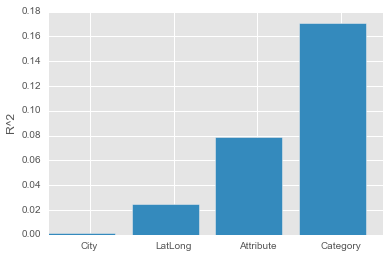

In [30]:
plt.bar([1,2,3,4],[0.00132602324228, 0.0248118636604, 0.0789390332998, 0.170443168974])
plt.xticks([1.5,2.5,3.5,4.5], ['City','LatLong','Attribute','Category'])
#plt.gca().set_xticklabel(['City','LatLong','Attribute','Category'])
#plt.g
#plt.xticks(['City','LatLong','Attribute','Category'])
f = plt.gcf()
f.set_size_inches(6,4)
plt.ylabel("R^2")
plt.savefig('ML_Yelp_Bus.png',dpi=300)